# Late Fusion Model for Prediction of Recurrence 

In [ ]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 15.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pip install pydicom
#pip install pydot
#pip install pydotplus
#pip install graphviz

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
import numpy as np
import collections
from collections import Counter
import random
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


pd.set_option('display.max_columns', None)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

# Building Neural Network

### Validation and Training Sets for both data

In [ ]:
image_dataset = np.load(r"C:\Users\Catherine\Documents\University MSc\Computing Masters\DUKE_Breast_cancer\Datasets\2D\Breast_dataset-2D-256-Recurrence with identifier.npy", allow_pickle=True)
clinical_dataset = pd.read_csv(r"C:\Users\Catherine\Documents\University MSc\Computing Masters\DUKE_Breast_cancer\Models\Joint Models\Recurrence_clean_clinical.csv")
clinical_dataset = clinical_dataset.drop("Unnamed: 0", axis = 1)

In [ ]:
#google drive version
image_dataset = np.load("/content/drive/MyDrive/Datasets/Breast_dataset-2D-256-Recurrence with identifier.npy", allow_pickle=True)
clinical_dataset = pd.read_csv("/content/drive/MyDrive/Datasets/Recurrence_clean_clinical.csv")
clinical_dataset = clinical_dataset.drop("Unnamed: 0", axis = 1)

In [ ]:
print(image_dataset.shape)
print(len(clinical_dataset))
#clinical_dataset.columns

(848, 3)
857


In [ ]:
df = pd.DataFrame(image_dataset, columns =["image", "Recurrence", "Patient ID"])
df.head()

,image,Recurrence,Patient ID
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,Breast_MRI_001
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,Breast_MRI_002
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,Breast_MRI_003
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,Breast_MRI_004
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,Breast_MRI_005


In [ ]:
# note to self should have left patient IDs the same in original csv file rather than convert to numeric

In [ ]:
def file_name_edit(ID):
    ID = int(ID)
    num = str(ID).zfill(3)
    new_string= "Breast_MRI_"+str(num)
    return new_string

clinical_dataset["PatientID"] = clinical_dataset.apply(lambda row: file_name_edit(row["Patient ID"]), axis = 1)
clinical_dataset =clinical_dataset.drop(["Patient ID"], axis = 1)
clinical_dataset= clinical_dataset.rename(columns ={"PatientID" : "Patient ID"})
clinical_dataset.head()

,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),Staging(Tumor Size),Staging(Nodes),PR,HER2,Tumor Grade Tubule,Tumor Grade Mitotic,Tumor Grade Nuclear,Mol Subtype_Triple Negative,Race and Ethnicity_Hispanic,Race and Ethnicity_Asian,Patient ID
0,0,15209,0,2.0,1.0,0,1,3,1,2,0,0,0,Breast_MRI_001
1,0,14061,0,2.0,0.0,0,0,3,3,3,1,0,0,Breast_MRI_002
2,0,22685,1,2.0,1.0,1,0,3,1,2,0,0,0,Breast_MRI_003
3,0,21479,1,1.0,0.0,1,0,3,1,2,0,0,0,Breast_MRI_004
4,0,13932,0,2.0,1.0,0,1,3,3,3,0,1,0,Breast_MRI_005


In [ ]:
clinical_dataset["Menopause (at diagnosis)"].value_counts()

1    463
0    382
2     12
Name: Menopause (at diagnosis), dtype: int64

In [ ]:
print(len(clinical_dataset))

857


In [ ]:
#noticed this hadn't passed through correctly
clinical_dataset = clinical_dataset.loc[clinical_dataset["Menopause (at diagnosis)"] != 2]

In [ ]:
joint_df = pd.merge(df, clinical_dataset, on = ["Patient ID"] )
print(len(joint_df))

837


### this is just a unit test to make sure that the dataframes aligned correctly 

In [ ]:
def match(column1, column2):
    if column1 == column2:
        return 1
    else:
        return 0

joint_df['match'] = joint_df.apply(lambda row: match(row['Recurrence'], row['Recurrence event(s)']), axis=1)
joint_df['match'].value_counts()

1    837
Name: match, dtype: int64

In [ ]:
train_df, test_df = train_test_split(joint_df, test_size=0.3, random_state=42)

In [ ]:
train_image= train_df['image'].tolist()
test_image=test_df['image'].tolist()

train_label= train_df['Recurrence'].tolist()
test_label=test_df['Recurrence'].tolist()

## 2D Convolutional Neural Network

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 4

In [ ]:
X_train_image = np.asarray(train_image).astype(np.float32)
y_train_image = np.asarray(train_label).astype(np.float32)
X_test_image = np.asarray(test_image).astype(np.float32)
y_test_image = np.asarray(test_label).astype(np.float32)

In [ ]:
X_train_image.shape

(585, 256, 256)

In [ ]:
y_train_image.shape

(585,)

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train_image, y_train_image))
test_loader = tf.data.Dataset.from_tensor_slices((X_test_image, y_test_image))

rotate function doesn't work yet , note to self do I need to standardize the image .255 if there is no colour

In [ ]:
def train_preprocessing(images, labels):
    
    #images - tf.resize(images, [128,128])
    images = tf.expand_dims(images, axis =3)
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.cast(images, tf.float32) /255.
    
    return (images, labels)


def validation_preprocessing(images, labels):
        
    images = tf.expand_dims(images, axis =3)
    images = tf.cast(images, tf.float32) /255.
    
    return (images, labels)

In [ ]:
train_dataset = (
    train_loader
    .batch(BATCH_SIZE)
    .map(train_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset =(
    test_loader
    .batch(BATCH_SIZE)
    .map(validation_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

0.0
Dimension of the MRI scan is: (256, 256, 1)


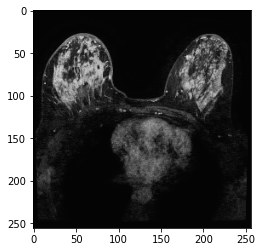

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print(labels.numpy()[0])
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(image.squeeze(), cmap="gray")

### Define the Model 

In [ ]:
def create_image_model():
    tensor_shape = (IMG_SIZE, IMG_SIZE, 1)

    img_input = Input(shape=(tensor_shape))

    x = Conv2D(32, (3,3), activation="relu")(img_input)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3,3), activation="relu")(x)
    #x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3,3), activation="relu")(x)
    #x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)


    x = Conv2D(256, (3,3), activation="relu")(x)

    x =GlobalAveragePooling2D()(x)
    x = Dense(units=129, activation="relu")(x)
    x = Dropout(0.2)(x)

    predictions = Dense(1, activation = "sigmoid")(x)

    model_image = Model(inputs = img_input, outputs = predictions)
    # Compile model.

    initial_learning_rate = 0.0001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )

    model_image.compile(optimizer=tf.optimizers.Adam(learning_rate = lr_schedule),
              loss='binary_crossentropy',
              metrics= METRICS)
    return model_image

In [ ]:
model_image = create_image_model()

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_recurrence.h5", save_best_only=True
)

#early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
early_stopping_cb  = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience = 10, restore_best_weights = True)

## Rebalancing Class Weights

In [ ]:

num0 = np.count_nonzero(y_train_image == np.array(0))
num1 = np.count_nonzero(y_train_image == np.array(1))
org_size = {0 : num0 , 1 : num1}

n_classes= 2 
n_sample0= int(org_size.get(0))
n_sample1= int(org_size.get(1))
n_samples= n_sample0 + n_sample1
    

#Weights for class 0 (no reccurence):
w0=  n_samples/(n_classes*n_sample0) 

#Weights for class 1 (cancer recurence):
w1= n_samples/(n_classes*n_sample1)

class_weights = {0:w0*2, 1: w1*2}
print(org_size)
print(class_weights)

{0: 526, 1: 59}
{0: 1.1121673003802282, 1: 9.915254237288135}


## Run the Model

In [ ]:
image_history = model_image.fit(train_dataset,   
                    class_weight =class_weights,
                    validation_data = validation_dataset,
                    callbacks=[checkpoint_cb],
                    batch_size = BATCH_SIZE,
                    verbose = 2,
                    epochs=50)

Epoch 1/50
147/147 - 7s - loss: 1.5120 - tp: 27.0000 - fp: 262.0000 - tn: 264.0000 - fn: 32.0000 - accuracy: 0.4974 - precision: 0.0934 - recall: 0.4576 - auc: 0.4860 - prc: 0.1106 - val_loss: 0.5585 - val_tp: 1.0000 - val_fp: 10.0000 - val_tn: 218.0000 - val_fn: 23.0000 - val_accuracy: 0.8690 - val_precision: 0.0909 - val_recall: 0.0417 - val_auc: 0.4293 - val_prc: 0.0842 - 7s/epoch - 47ms/step
Epoch 2/50
147/147 - 7s - loss: 1.4621 - tp: 28.0000 - fp: 268.0000 - tn: 258.0000 - fn: 31.0000 - accuracy: 0.4889 - precision: 0.0946 - recall: 0.4746 - auc: 0.4908 - prc: 0.1105 - val_loss: 0.6305 - val_tp: 4.0000 - val_fp: 42.0000 - val_tn: 186.0000 - val_fn: 20.0000 - val_accuracy: 0.7540 - val_precision: 0.0870 - val_recall: 0.1667 - val_auc: 0.4551 - val_prc: 0.0896 - 7s/epoch - 45ms/step
Epoch 3/50
147/147 - 7s - loss: 1.4431 - tp: 25.0000 - fp: 259.0000 - tn: 267.0000 - fn: 34.0000 - accuracy: 0.4991 - precision: 0.0880 - recall: 0.4237 - auc: 0.4426 - prc: 0.1037 - val_loss: 0.6340 - 

# Transfer Learning Mobilenet_v2 Model

In [ ]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))
feature_extractor_layer.trainable = False

In [ ]:
def mobilenet_preprocessing(images, labels):
    images = tf.expand_dims(images, -1)
    images = tf.image.resize(images,[224,224])
    images = tf.image.grayscale_to_rgb(images)
    images = tf.keras.applications.mobilenet_v2.preprocess_input (images)
    return (images, labels)

train_dataset = (
    train_loader
    .batch(BATCH_SIZE)
    .map(mobilenet_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    test_loader
    .batch(BATCH_SIZE)
    .map(mobilenet_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

0.0
Dimension of the MRI scan is: (224, 224, 3)


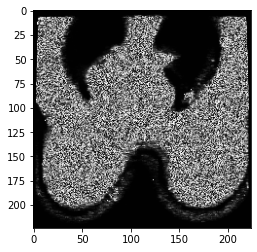

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print(labels.numpy()[0])
print("Dimension of the MRI scan is:", image.shape)
plt.imshow((image * 255).astype(np.uint8))

In [ ]:
myModel = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top= False,
    weights="imagenet",
    classes=2,
    pooling=None,
    classifier_activation="sigmoid")

nn_inputs = myModel.input

for layer in myModel.layers:
        layer.trainable = False


myModelOut = myModel.output
myModelOut = GlobalAveragePooling2D()(myModelOut)
myModelOut = Dense(1, activation="sigmoid")(myModelOut)

model_image = Model(inputs=nn_inputs, outputs=myModelOut)

model_image.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
  initial_learning_rate = 0.0001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  )
model_image.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss = "binary_crossentropy",
    metrics=METRICS)

In [ ]:
history_image = model_image.fit(train_dataset,
                                   validation_data=validation_dataset,
                                   batch_size = BATCH_SIZE,
                                   class_weight = class_weights,
                                   epochs=20
                                  )

Epoch 1/20
147/147 [==============================] - 9s 34ms/step - loss: 1.5229 - tp: 38.0000 - fp: 304.0000 - tn: 450.0000 - fn: 45.0000 - accuracy: 0.5830 - precision: 0.1111 - recall: 0.4578 - auc: 0.5305 - prc: 0.1141 - val_loss: 0.7594 - val_tp: 9.0000 - val_fp: 115.0000 - val_tn: 113.0000 - val_fn: 15.0000 - val_accuracy: 0.4841 - val_precision: 0.0726 - val_recall: 0.3750 - val_auc: 0.4647 - val_prc: 0.1477
Epoch 2/20
147/147 [==============================] - 4s 24ms/step - loss: 1.4628 - tp: 32.0000 - fp: 241.0000 - tn: 285.0000 - fn: 27.0000 - accuracy: 0.5419 - precision: 0.1172 - recall: 0.5424 - auc: 0.5204 - prc: 0.0980 - val_loss: 0.7449 - val_tp: 11.0000 - val_fp: 113.0000 - val_tn: 115.0000 - val_fn: 13.0000 - val_accuracy: 0.5000 - val_precision: 0.0887 - val_recall: 0.4583 - val_auc: 0.4728 - val_prc: 0.1297
Epoch 3/20
147/147 [==============================] - 3s 20ms/step - loss: 1.4234 - tp: 33.0000 - fp: 225.0000 - tn: 301.0000 - fn: 26.0000 - accuracy: 0.5709 

# Clinical Model

## Train and Validation data

In [ ]:
clinical_train = train_df[['Recurrence event(s)', 'Date of Birth (Days)',
       'Menopause (at diagnosis)', 'Staging(Tumor Size)', 'Staging(Nodes)',
       'PR', 'HER2', 'Tumor Grade Tubule', 'Tumor Grade Mitotic',
       'Tumor Grade Nuclear', 'Mol Subtype_Triple Negative',
       'Race and Ethnicity_Hispanic', 'Race and Ethnicity_Asian']]

clinical_test = test_df[['Recurrence event(s)', 'Date of Birth (Days)',
       'Menopause (at diagnosis)', 'Staging(Tumor Size)', 'Staging(Nodes)',
       'PR', 'HER2', 'Tumor Grade Tubule', 'Tumor Grade Mitotic',
       'Tumor Grade Nuclear', 'Mol Subtype_Triple Negative',
       'Race and Ethnicity_Hispanic', 'Race and Ethnicity_Asian']]

In [ ]:
clinical_train.head()

,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),Staging(Tumor Size),Staging(Nodes),PR,HER2,Tumor Grade Tubule,Tumor Grade Mitotic,Tumor Grade Nuclear,Mol Subtype_Triple Negative,Race and Ethnicity_Hispanic,Race and Ethnicity_Asian
234,0,16563,0,3.0,1.0,0,1,3,1,2,0,0,0
220,0,16603,0,4.0,0.0,1,1,2,1,3,0,0,1
316,0,26526,1,1.0,0.0,1,0,2,2,2,0,0,0
333,0,19192,1,1.0,0.0,0,1,3,3,3,0,0,0
132,0,23629,1,3.0,0.0,1,0,3,1,2,0,0,0


In [ ]:
print(len(clinical_train))
print(len(clinical_test))

585
252


In [ ]:
def test_train_dataset(train_df, test_df, label):

    print(train_df.columns)
    
    # Form np arrays of labels and features.
    y_train = np.array(train_df.pop(label))
    y_test = np.array(test_df.pop(label))

    X_train = np.array(train_df)
    X_test = np.array(test_df)
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train_clinical, X_test_clinical, y_train_clinical, y_test_clinical = test_train_dataset(clinical_train, clinical_test, 'Recurrence event(s)')

Index(['Recurrence event(s)', 'Date of Birth (Days)',
       'Menopause (at diagnosis)', 'Staging(Tumor Size)', 'Staging(Nodes)',
       'PR', 'HER2', 'Tumor Grade Tubule', 'Tumor Grade Mitotic',
       'Tumor Grade Nuclear', 'Mol Subtype_Triple Negative',
       'Race and Ethnicity_Hispanic', 'Race and Ethnicity_Asian'],
      dtype='object')


In [ ]:
scaler = preprocessing.StandardScaler()

X_train_clinical = scaler.fit_transform(X_train_clinical)
X_test_clinical = scaler.transform(X_test_clinical)

## Class Weights

In [ ]:
org_size = collections.Counter(y_train_clinical) 

n_classes= 2 
n_sample0= int(org_size.get(0))
n_sample1= int(org_size.get(1))
n_samples= n_sample0 + n_sample1
    

#Weights for class 0 (no response):
w0=  n_samples/(n_classes*n_sample0) 

#Weights for class 1 (complete or partial response):
w1= n_samples/(n_classes*n_sample1)

class_weights = {0:w0*2, 1: w1*2}
print(org_size)
print(class_weights)

Counter({0: 526, 1: 59})
{0: 1.1121673003802282, 1: 9.915254237288135}


#Simple Convoloutional Neural Network

In [ ]:
input_shape = X_train_clinical.shape[1]
print(input_shape)

12


In [ ]:
img_input = Input(shape =( input_shape,))

x =Dense(64, activation = "relu")(img_input)
x = Dense(128, activation = "relu")(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.4)(x)
x = Dense(64, activation = "relu")(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation = "sigmoid")(x)

model_clinical = Model(inputs = img_input, outputs = predictions)

In [ ]:
model_clinical.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.001),
                    loss = "binary_crossentropy",
                    metrics = METRICS)

early_stop = keras.callbacks.EarlyStopping(monitor = "val_auc", patience = 10, restore_best_weights = True)

In [ ]:
clinical_history = model_clinical.fit(X_train_clinical,
                             y_train_clinical,
                             batch_size = BATCH_SIZE,
                             validation_data = (X_test_clinical, y_test_clinical),
                             class_weight = class_weights,
                             callbacks= [early_stop],
                             verbose = 2,
                             epochs = 80)

Epoch 1/80
147/147 - 6s - loss: 0.7700 - tp: 73.0000 - fp: 85.0000 - tn: 695.0000 - fn: 8.0000 - accuracy: 0.8920 - precision: 0.4620 - recall: 0.9012 - auc: 0.9546 - prc: 0.7801 - val_loss: 2.1237 - val_tp: 5.0000 - val_fp: 39.0000 - val_tn: 189.0000 - val_fn: 19.0000 - val_accuracy: 0.7698 - val_precision: 0.1136 - val_recall: 0.2083 - val_auc: 0.4900 - val_prc: 0.1016 - 6s/epoch - 41ms/step
Epoch 2/80
147/147 - 2s - loss: 0.4049 - tp: 55.0000 - fp: 58.0000 - tn: 468.0000 - fn: 4.0000 - accuracy: 0.8940 - precision: 0.4867 - recall: 0.9322 - auc: 0.9754 - prc: 0.8520 - val_loss: 2.1151 - val_tp: 4.0000 - val_fp: 43.0000 - val_tn: 185.0000 - val_fn: 20.0000 - val_accuracy: 0.7500 - val_precision: 0.0851 - val_recall: 0.1667 - val_auc: 0.4868 - val_prc: 0.0956 - 2s/epoch - 13ms/step
Epoch 3/80
147/147 - 2s - loss: 0.3324 - tp: 56.0000 - fp: 52.0000 - tn: 474.0000 - fn: 3.0000 - accuracy: 0.9060 - precision: 0.5185 - recall: 0.9492 - auc: 0.9790 - prc: 0.8592 - val_loss: 2.2459 - val_tp

## Hyperparameter Tuning Version

In [ ]:
input_shape = X_train_clinical.shape[1]
print(input_shape)

12


In [ ]:
def model_builder(hp):
    
    img_input = Input(shape=(input_shape, ))

    hp_input_units = hp.Int('input_units', min_value=32, max_value=512, step=32)
    
    x = Dense((hp_input_units), activation = "relu")(img_input)
    
    for i in range(hp.Int("num_layers", min_value = 1, max_value = 4)):
        x = Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, 
                         step=32), activation = "relu")(x)
        x = Dropout(hp.Float(f"dropout_{i}", min_value =0, max_value =0.5, step = 0.1))(x)
        
    predictions = Dense(1, activation = "sigmoid")(x)

    model = Model(inputs = img_input, outputs = predictions)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate = hp_learning_rate),
              loss='binary_crossentropy',
              metrics= METRICS) 
    
    return model

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "clinical_classification.h5", save_best_only=True
)

early_stop = keras.callbacks.EarlyStopping(monitor="val_auc",
                                           patience=15, 
                                           restore_best_weights =True)

In [ ]:
tuner_bayes = kt.BayesianOptimization(
    model_builder,
    objective=kt.Objective('val_auc', direction='max'),
    overwrite=True,
    max_trials=80,
    directory = "trails",
    project_name="trials_reccurence_bayes"
    )

In [ ]:
tuner_bayes.search(X_train_clinical,
             y_train_clinical,
             batch_size= BATCH_SIZE,
             validation_data = (X_test_clinical, y_test_clinical), 
             class_weight =class_weights,
             callbacks=[checkpoint_cb, early_stop],
             verbose = 1,
             epochs=20)

Trial 80 Complete [00h 00m 25s]
val_auc: 0.5988669991493225

Best val_auc So Far: 0.659904956817627
Total elapsed time: 00h 59m 18s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner_bayes.get_best_hyperparameters(1)[0]
print(best_hps.values)

{'input_units': 512, 'num_layers': 1, 'dense_0_units': 512, 'dropout_0': 0.0, 'learning_rate': 0.01, 'dense_1_units': 512, 'dropout_1': 0.5, 'dense_2_units': 32, 'dropout_2': 0.5, 'dense_3_units': 32, 'dropout_3': 0.0}


In [ ]:
bestHP = tuner_bayes.get_best_hyperparameters(num_trials=1)[0]

model_clinical = tuner_bayes.hypermodel.build(bestHP)

history = model_clinical.fit(X_train_clinical,
              y_train_clinical,
              batch_size= BATCH_SIZE,
              validation_data = (X_test_clinical, y_test_clinical), 
              class_weight =class_weights,
              callbacks=[early_stop],
              verbose = 1,
              epochs=80)

Epoch 1/80
147/147 [==============================] - 3s 13ms/step - loss: 1.8269 - tp: 45.0000 - fp: 298.0000 - tn: 456.0000 - fn: 38.0000 - accuracy: 0.5986 - precision: 0.1312 - recall: 0.5422 - auc: 0.5952 - prc: 0.1468 - val_loss: 0.9605 - val_tp: 19.0000 - val_fp: 166.0000 - val_tn: 62.0000 - val_fn: 5.0000 - val_accuracy: 0.3214 - val_precision: 0.1027 - val_recall: 0.7917 - val_auc: 0.5182 - val_prc: 0.0997
Epoch 2/80
147/147 [==============================] - 1s 7ms/step - loss: 1.5609 - tp: 42.0000 - fp: 243.0000 - tn: 283.0000 - fn: 17.0000 - accuracy: 0.5556 - precision: 0.1474 - recall: 0.7119 - auc: 0.6593 - prc: 0.1629 - val_loss: 0.7834 - val_tp: 11.0000 - val_fp: 86.0000 - val_tn: 142.0000 - val_fn: 13.0000 - val_accuracy: 0.6071 - val_precision: 0.1134 - val_recall: 0.4583 - val_auc: 0.5712 - val_prc: 0.1188
Epoch 3/80
147/147 [==============================] - 1s 8ms/step - loss: 1.5656 - tp: 38.0000 - fp: 231.0000 - tn: 295.0000 - fn: 21.0000 - accuracy: 0.5692 - pr

# Model Evaluation

In [ ]:
# Save the weights
model_clinical.save_weights('./checkpoints/clinical')

# Create a new model instance
model_clinical = create_model()

# Restore the weights
model_clinical.load_weights('./checkpoints/clinical')

In [ ]:
# Save the weights
model_image.save_weights('./checkpoints/clinical')

# Create a new model instance
model_image= create_model()

# Restore the weights
model_image.load_weights('./checkpoints/clinical')

In [ ]:
def plot_metrics(history, list_of_metrics):
    
    rows = int(np.ceil(len(list_of_metrics)/2))
    columns = 2
    
    fig, ax = plt.subplots(rows, columns, figsize=(20, 10))
    ax = ax.ravel()

    for i, metric in enumerate(list_of_metrics):
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

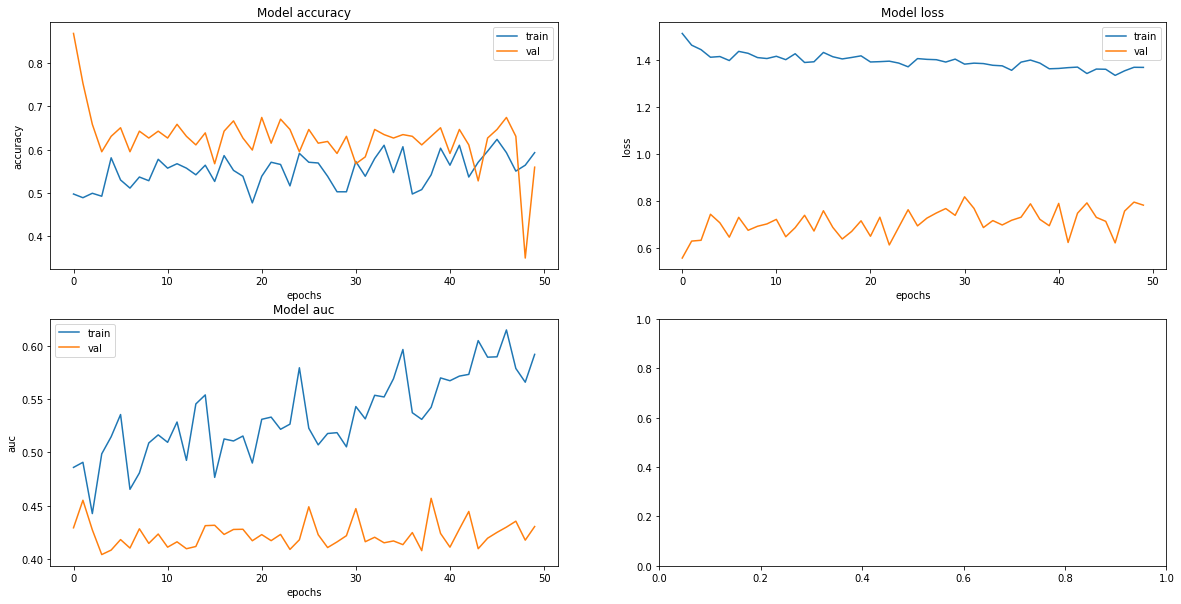

In [ ]:
plot_metrics(image_history, ["accuracy", "loss", "auc"])

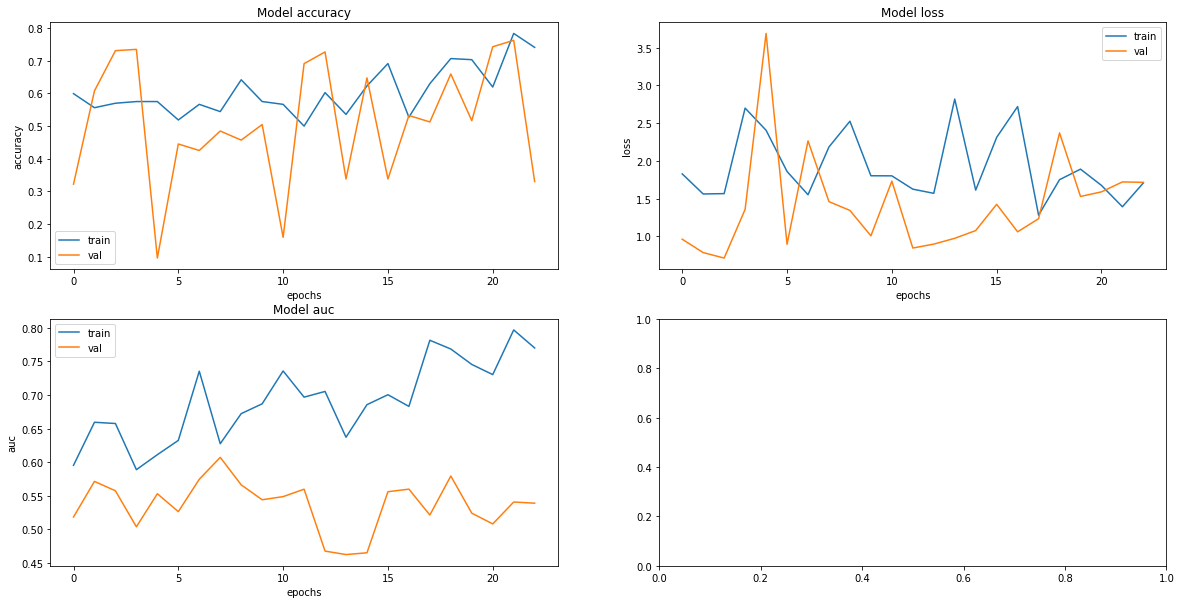

In [ ]:
plot_metrics(history, ["accuracy", "loss", "auc"])

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

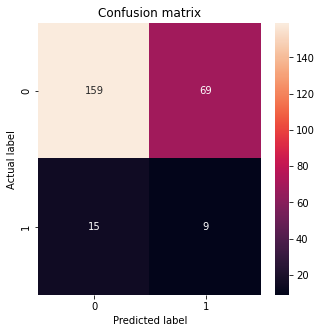

In [ ]:
test_predictions_baseline = model_image.predict(validation_dataset, batch_size=BATCH_SIZE)
plot_cm(y_test_image, test_predictions_baseline)

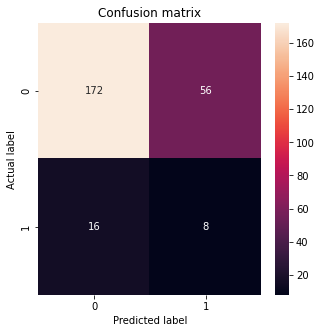

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
test_predictions_baseline = model_clinical.predict(X_test_clinical, batch_size=BATCH_SIZE)
plot_cm(y_test_clinical, test_predictions_baseline)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
      
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    ax = plt.gca()
    ax.set_aspect('equal')

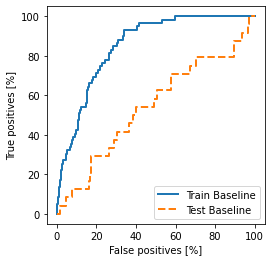

In [ ]:
train_predictions_baseline = model_image.predict(train_dataset, batch_size=BATCH_SIZE)
test_predictions_baseline = model_image.predict(validation_dataset, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train_image, train_predictions_baseline)
plot_roc("Test Baseline", y_test_image, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

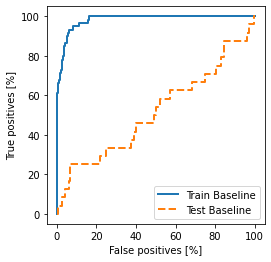

In [ ]:
train_predictions_baseline = model_clinical.predict(X_train_clinical, batch_size=BATCH_SIZE)
test_predictions_baseline = model_clinical.predict(X_test_clinical, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train_clinical, train_predictions_baseline)
plot_roc("Test Baseline", y_test_clinical, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

In [ ]:
baseline_results = model_image.evaluate(validation_dataset,batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_image.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  0.6222262978553772
tp :  9.0
fp :  69.0
tn :  159.0
fn :  15.0
accuracy :  0.6666666865348816
precision :  0.11538461595773697
recall :  0.375
auc :  0.5413011312484741
prc :  0.10982160270214081


In [ ]:
baseline_results = model_clinical.evaluate(X_test_clinical, y_test_clinical,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_clinical.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  1.775846242904663
tp :  8.0
fp :  56.0
tn :  172.0
fn :  16.0
accuracy :  0.7142857313156128
precision :  0.125
recall :  0.3333333432674408
auc :  0.5401133298873901
prc :  0.12980154156684875


# Joint Fusion

In [ ]:
#model.load_weights("clinical_classification.h5")

prediction = model_clinical.predict(np.expand_dims(X_test_clinical[0], axis=0))[0]
print("Actual :", y_test_clinical[0])
scores = [1 - prediction[0], prediction[0]]

class_names = ["no recurrence", "recurrence"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that this patient will have %s"
        % ((100 * score), name)
    )

Actual : 0
This model is 100.00 percent confident that this patient will have no recurrence
This model is 0.00 percent confident that this patient will have recurrence


this image is 56.34 confident of no recurrence
this image is 43.66 confident of recurrence


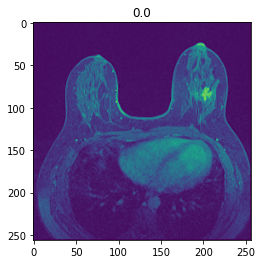

In [ ]:
class_names = ["no recurrence", "recurrence"]
for image , label in validation_dataset.take(1):
    image = image.numpy()
    label = label.numpy()
    image = image[0]
    plt.imshow(image.squeeze())
    plt.title(str(label[0]))
    
prediction = model_image.predict(validation_dataset.take(1))[0]
scores = [1-prediction, prediction]

for score, name in zip(scores, class_names):
    print("this image is %.2f confident of %s" % ((100*score), name))

In [ ]:
print(len(y_test_clinical))
print(collections.Counter(y_test_clinical) )

252
Counter({0: 228, 1: 24})


In [ ]:
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []

fusion_values = []

def process(image):
    image = tf.cast(image, tf.float32) /255.
    return image
#
def process_mobilenet(images):
    images = tf.expand_dims(images, -1)
    images = tf.image.resize(images,[224,224])
    images = tf.image.grayscale_to_rgb(images)
    images = tf.keras.applications.mobilenet_v2.preprocess_input (images)
    return image


for index in range(0, len(y_test_clinical)):
    prediction_image = model_image.predict(np.expand_dims(process_mobilenet(X_test_image[index]), axis=0))[0]

    #prediction_image = model_image.predict(np.expand_dims(process(X_test_image[index]), axis=0))[0]
    prediction_clinical = model_clinical.predict(np.expand_dims(X_test_clinical[index], axis = 0))[0]

    print("Actual :", y_test_clinical[index], y_test_image[index])
    print(prediction_image, prediction_clinical)

    fusion = (0.5*prediction_image)+(0.5*prediction_clinical)
    fusion_values.append(fusion[0])
    print(fusion)

    if np.around(fusion) == 1 and y_test_clinical[index] == 1:
        true_positives.append(fusion)
    elif np.around(fusion) == 1 and y_test_clinical[index] == 0:
        false_positives.append(fusion)
    elif np.around(fusion) == 0 and y_test_clinical[index] == 0:
        true_negatives.append(fusion)
    elif np.around(fusion) == 0 and y_test_clinical[index] == 1:
        false_negatives.append(fusion)
    else:
        print("error")   



Actual : 0 0.0
[0.24254654] [3.6348197e-08]
[0.12127329]
Actual : 0 0.0
[0.24254654] [0.02361567]
[0.13308111]
Actual : 0 0.0
[0.24254654] [3.147541e-08]
[0.12127329]
Actual : 0 0.0
[0.24254654] [0.99993896]
[0.62124276]
Actual : 0 0.0
[0.24254654] [0.00810526]
[0.1253259]
Actual : 0 0.0
[0.24254654] [3.8017435e-13]
[0.12127327]
Actual : 0 0.0
[0.24254654] [9.538326e-05]
[0.12132096]
Actual : 0 0.0
[0.24254654] [0.8457387]
[0.5441426]
Actual : 0 0.0
[0.24254654] [0.5760571]
[0.40930182]
Actual : 0 0.0
[0.24254654] [0.00487739]
[0.12371197]
Actual : 1 1.0
[0.24254654] [0.00852872]
[0.12553763]
Actual : 0 0.0
[0.24254654] [6.0157645e-06]
[0.12127628]
Actual : 0 0.0
[0.24254654] [2.0722055e-06]
[0.12127431]
Actual : 0 0.0
[0.24254654] [1.0222487e-06]
[0.12127379]
Actual : 0 0.0
[0.24254654] [3.3670273e-07]
[0.12127344]
Actual : 0 0.0
[0.24254654] [1.3196464e-13]
[0.12127327]
Actual : 0 0.0
[0.24254654] [0.9985996]
[0.62057304]
Actual : 0 0.0
[0.24254654] [0.02131758]
[0.13193206]
Actual :

# Calculations 

* Accuracy = correct guesses/ total number of values
* Precision = TruePositives / (TruePositives + FalsePositives)
* Recall = TruePositives / (TruePositives + FalseNegatives)
* F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

In [ ]:
print(len(true_positives))
print(len(true_negatives))
print(len(false_positives))
print(len(false_negatives))

6
197
31
18


In [ ]:
def metrics(tp, tn, fp, fn):
    accuracy = (tp+tn)/(tp +tn +fp +fn)
    precision = tp / (tp +fp)
    recall = tp / (tp+fn)
    f1 = 2* (precision * recall)/ (precision + recall)
    print("accuracy: ", accuracy)
    print("precision: ", precision)
    print("recall: ", recall)
    print("f1: ", f1)

metrics(len(true_positives), len(true_negatives), len(false_positives), len(false_negatives))

accuracy:  0.8055555555555556
precision:  0.16216216216216217
recall:  0.25
f1:  0.19672131147540983
